In [16]:
import numpy as np
import pandas as pd
from Evaluator import ModelEvaluator
import torch
import random
from matplotlib import pylab as plt
from IPython.display import clear_output

In [17]:
data=pd.read_csv('datasets/malicious_data_generated.csv')
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 10)


In [18]:
class MalwareEnv():
    def __init__(self):
        # Actions we can take, decrease, increse
        self.action_space = 20  
        # Set start 
        self.state = np.asarray(malData[random.randint(0,498),:])
        #model to evaluate the reward
        self.evaluator=ModelEvaluator()
        #units to move
        self.block=10
        
        
    def step(self, action):
        
        if(action<9):
            self.state[action]+=self.block
        elif(action>=9 and action<19):
            self.state[action-9]-=self.block
            
        
    def reward(self):
        reward=-1
        value=self.state.tolist()
        result=self.evaluator.test(value)
        result=np.array2string(result)
        
        if(result=="['benign']"):
                 reward=+10
                 
        return reward    

    def render_np(self):
        return self.state
    

In [19]:


l1 = 10
l2 = 24
l3 = 72
l4 = 20
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
#device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.cuda()
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [21]:
epochs = 1500
losses = [] 

for i in range(epochs): 
    env = MalwareEnv() 
    state_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0 
    state1 = torch.from_numpy(state_).float() 
    status = 1 
    while(status == 1): 
        qval = model(state1.cuda()) 
        qval_ = qval.data.cpu().numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,20)
        else:
            action_ = np.argmax(qval_)
        
        env.step(action_) 
        state2_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0
        state2 = torch.from_numpy(state2_).float() 
        reward = env.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,10).cuda())
        maxQ = torch.max(newQ) 
        if reward == -1: 
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] 
        loss = loss_fn(X.cuda(), Y.cuda()) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: 
            status = 0
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

KeyboardInterrupt: 

In [ ]:
losses
#clear_output(wait=True)

[81.40229034423828,
 136.6539306640625,
 1.5434681177139282,
 337.3750305175781,
 8.227325439453125,
 197.3077850341797,
 54.66543960571289,
 451.9638366699219,
 325.3589782714844,
 41.804290771484375,
 57.50333023071289,
 6.541508197784424,
 82.91435241699219,
 55.11550521850586,
 11.228423118591309,
 9.463408470153809,
 8.394895553588867,
 93.67666625976562,
 20.3978328704834,
 62.44773864746094,
 2.4912972450256348,
 14.390368461608887,
 4.468173980712891,
 42.86393356323242,
 2.5591108798980713,
 2.3014111518859863,
 78.76201629638672,
 3.3653318881988525,
 3.2582619190216064,
 115.96033477783203,
 65.24189758300781,
 0.28306517004966736,
 0.5563769936561584,
 0.8888782262802124,
 0.05296473577618599,
 0.6882026791572571,
 11.912361145019531,
 2.4204704761505127,
 8.193161964416504,
 6.893282413482666,
 2.64123797416687,
 0.9260420799255371,
 0.5017843246459961,
 65.90401458740234,
 0.9300665259361267,
 34.24802780151367,
 25.64022445678711,
 44.96705627441406,
 82.3624267578125,
 

Text(0, 0.5, 'Loss')

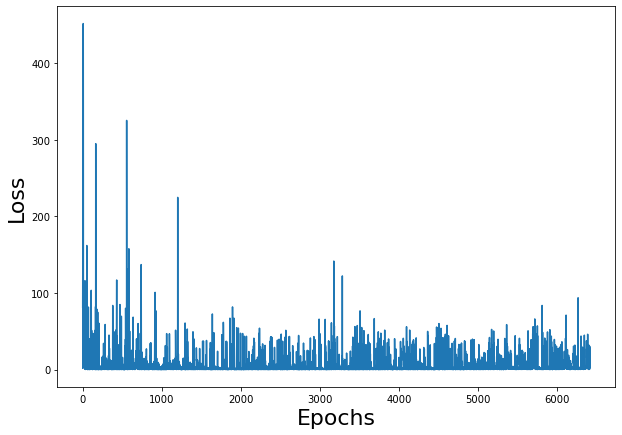

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)